#Part1: VAE model on the Grayscale images



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install gradio
import gradio as gr

In [ ]:
latent_dim = 64
input_shape = (1, 32, 32)
batch_size = 128
epochs = 30
learning_rate = 0.001
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Resize((32, 32)),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_log_var = nn.Linear(256 * 8 * 8, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 256, 8, 8)
        x = self.deconv(x)
        return x

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var

In [ ]:
def vae_loss(inputs, outputs, mu, log_var):
    inputs = torch.clamp(inputs, 0, 1)
    reconstruction_loss = nn.functional.binary_cross_entropy(outputs, inputs, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (reconstruction_loss + kl_divergence) / inputs.size(0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [ ]:
def train_vae(model, dataloader, optimizer, device, epochs, latent_dim):
  model.train()
  training_losses = []

  for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
      inputs, _ = batch
      inputs = inputs.to(device)

      optimizer.zero_grad()
      outputs, mu, log_var = model(inputs)
      loss = vae_loss(inputs, outputs, mu, log_var)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()


    avg_loss = total_loss / len(dataloader.dataset)
    training_losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")


  plt.figure(figsize=(10, 5))
  plt.plot(range(epochs), training_losses, label="Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training Loss for VAE")
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
def generate_images(decoder, latent_dim, num_images=10, device='cpu'):
    decoder.eval()
    with torch.no_grad():
        random_latent_vectors = torch.randn(num_images, latent_dim).to(device)
        generated_images = decoder(random_latent_vectors).cpu().numpy()
    return generated_images

In [ ]:
def plot_images(images, title="Generated Images"):
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

Epoch 1/30, Loss: 1.3441
Epoch 2/30, Loss: 0.9275
Epoch 3/30, Loss: 0.8953
Epoch 4/30, Loss: 0.8824
Epoch 5/30, Loss: 0.8740
Epoch 6/30, Loss: 0.8676
Epoch 7/30, Loss: 0.8629
Epoch 8/30, Loss: 0.8594
Epoch 9/30, Loss: 0.8557
Epoch 10/30, Loss: 0.8525
Epoch 11/30, Loss: 0.8499
Epoch 12/30, Loss: 0.8474
Epoch 13/30, Loss: 0.8451
Epoch 14/30, Loss: 0.8433
Epoch 15/30, Loss: 0.8414
Epoch 16/30, Loss: 0.8402
Epoch 17/30, Loss: 0.8382
Epoch 18/30, Loss: 0.8364
Epoch 19/30, Loss: 0.8353
Epoch 20/30, Loss: 0.8343
Epoch 21/30, Loss: 0.8328
Epoch 22/30, Loss: 0.8321
Epoch 23/30, Loss: 0.8298
Epoch 24/30, Loss: 0.8293
Epoch 25/30, Loss: 0.8287
Epoch 26/30, Loss: 0.8277
Epoch 27/30, Loss: 0.8266
Epoch 28/30, Loss: 0.8259
Epoch 29/30, Loss: 0.8247
Epoch 30/30, Loss: 0.8240


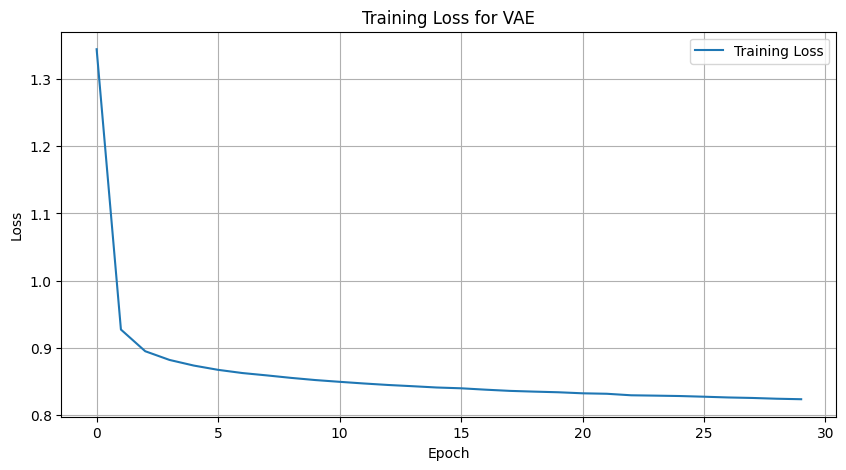

In [ ]:
train_vae(vae, train_loader, optimizer, device, epochs, latent_dim)

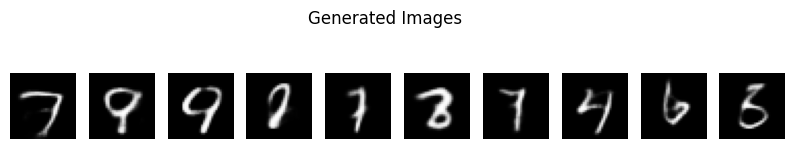

In [ ]:
generated_images = generate_images(vae.decoder, latent_dim, num_images=10, device=device)
plot_images(generated_images)

## GUI for part 1

In [ ]:
def train_model(epochs, latent_dim):
    global vae, optimizer
    train_vae(vae, train_loader, optimizer, device, epochs, latent_dim)
    return f"Training completed for {epochs} epochs with latent dimension {latent_dim}."


def generate_and_display_images(num_images):
    global vae
    generated_images = generate_images(vae.decoder, latent_dim, num_images=num_images, device=device)


    images = [img.squeeze() for img in generated_images]
    return images


def create_gui():
    with gr.Blocks() as demo:
        gr.Markdown("## Variational Autoencoder (VAE)")

        with gr.Tab("Train VAE"):
            epochs_input = gr.Number(label="Epochs", value=10)
            latent_dim_input = gr.Number(label="Latent Dimension", value=64)
            train_button = gr.Button("Train Model")
            train_output = gr.Textbox(label="Training Status")

            train_button.click(
                fn=train_model,
                inputs=[epochs_input, latent_dim_input],
                outputs=train_output
            )

        with gr.Tab("Generate Images"):
            num_images_input = gr.Slider(label="Number of Images", minimum=1, maximum=20, step=1, value=10)
            generate_button = gr.Button("Generate Images")
            images_output = gr.Gallery(label="Generated Images").style(grid=(1, 10))

            generate_button.click(
                fn=generate_and_display_images,
                inputs=num_images_input,
                outputs=images_output
            )

    return demo


if __name__ == "__main__":
    gui = create_gui()
    gui.launch()


#Part2:VAE on RGB


In [ ]:
latent_dim = 128
batch_size = 128
epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [ ]:
length=len(train_dataset)
print(length)

50000


In [ ]:
print(len(train_loader))

391


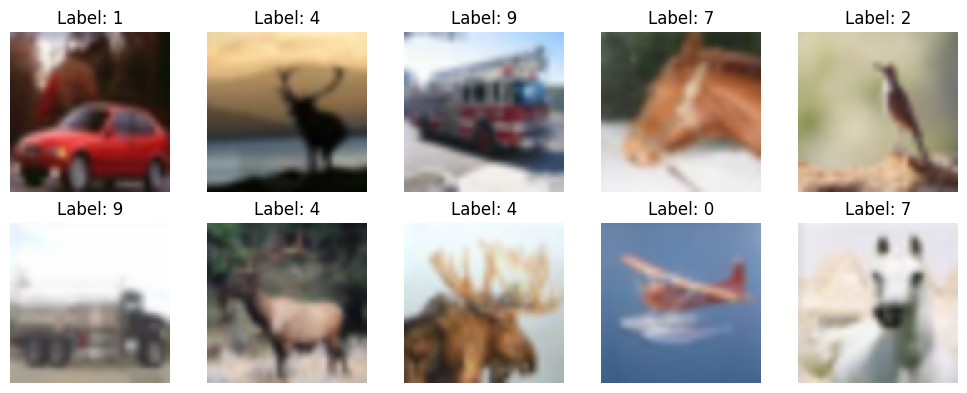

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128):
        super(VAEEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_log_var = nn.Linear(512 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

In [ ]:
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=128, output_channels=3):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, output_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)
        x = self.deconv(x)
        return x

In [ ]:
def sampling(mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

In [ ]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = sampling(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var

In [ ]:
def vae_loss(inputs, outputs, mu, log_var):
    reconstruction_loss = nn.MSELoss(reduction='sum')(outputs, inputs)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_loss

In [ ]:
encoder = VAEEncoder(input_channels=3, latent_dim=latent_dim).to(device)
decoder = VAEDecoder(latent_dim=latent_dim, output_channels=3).to(device)
vae = VAE(encoder, decoder).to(device)

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [ ]:
def train_vae(model, dataloader, optimizer, epochs, device):
  model.train()
  training_losses = []
  for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
      inputs, _ = batch
      inputs = inputs.to(device)

      optimizer.zero_grad()
      outputs, mu, log_var = model(inputs)
      loss = vae_loss(inputs, outputs, mu, log_var)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()


    avg_loss = total_loss / len(dataloader.dataset)
    training_losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")


  plt.figure(figsize=(10, 5))
  plt.plot(range(epochs), training_losses, label="Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training Loss for VAE On RGB")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
def generate_images(decoder, latent_dim, num_images=10, device='cpu'):
    decoder.eval()
    with torch.no_grad():
        random_latent_vectors = torch.randn(num_images, latent_dim).to(device)
        generated_images = decoder(random_latent_vectors).cpu().numpy()
    return generated_images

Epoch 1/30, Loss: 353.5929
Epoch 2/30, Loss: 192.7963
Epoch 3/30, Loss: 176.0397
Epoch 4/30, Loss: 168.6224
Epoch 5/30, Loss: 165.0718
Epoch 6/30, Loss: 163.1642
Epoch 7/30, Loss: 161.3659
Epoch 8/30, Loss: 160.2568
Epoch 9/30, Loss: 159.3044
Epoch 10/30, Loss: 158.3320
Epoch 11/30, Loss: 157.7439
Epoch 12/30, Loss: 157.0161
Epoch 13/30, Loss: 156.5303
Epoch 14/30, Loss: 156.2183
Epoch 15/30, Loss: 155.6392
Epoch 16/30, Loss: 155.0896
Epoch 17/30, Loss: 154.6272
Epoch 18/30, Loss: 154.2650
Epoch 19/30, Loss: 154.1248
Epoch 20/30, Loss: 153.9039
Epoch 21/30, Loss: 153.5134
Epoch 22/30, Loss: 153.1964
Epoch 23/30, Loss: 152.8815
Epoch 24/30, Loss: 152.7771
Epoch 25/30, Loss: 152.4456
Epoch 26/30, Loss: 152.2694
Epoch 27/30, Loss: 152.0514
Epoch 28/30, Loss: 151.8528
Epoch 29/30, Loss: 151.5217
Epoch 30/30, Loss: 151.5088


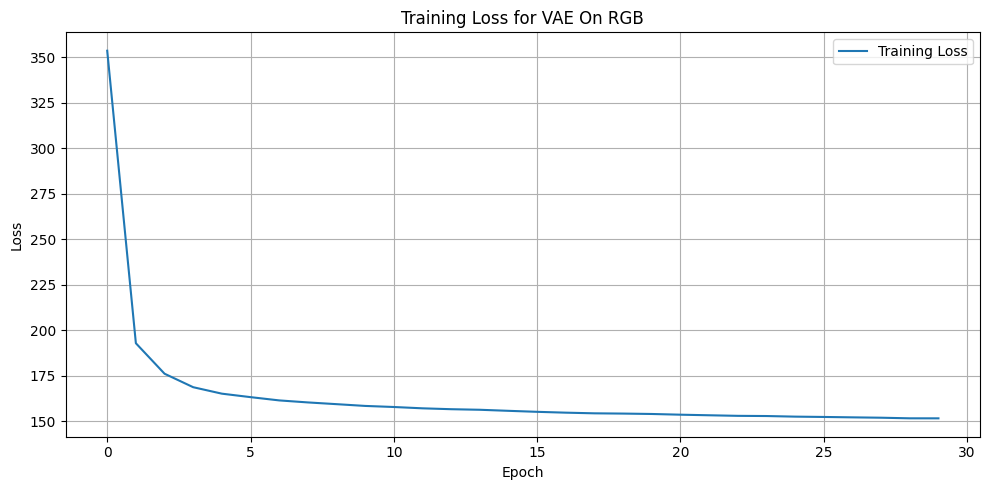

In [ ]:
train_vae(vae, train_loader, optimizer, epochs, device)

In [ ]:
vae_rgb_generated_images = generate_images(decoder, latent_dim, num_images=1500, device=device)

In [ ]:
def plot_images(images, title="Generated Images"):
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(images):
        img = np.transpose(img, (1, 2, 0))

        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

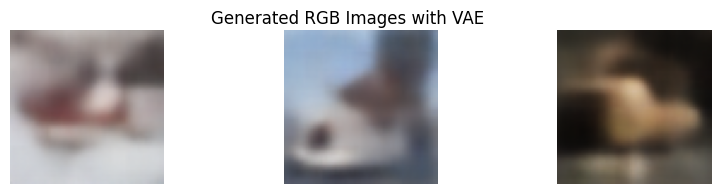

In [ ]:
plot_images(vae_rgb_generated_images[:3], title="Generated RGB Images with VAE")

## GUI for Part 2

In [ ]:
def train_model(epochs, latent_dim):
    global vae, optimizer
    train_vae(vae, train_loader, optimizer,  epochs, device)
    return f"Training completed for {epochs} epochs "


def generate_and_display_images(num_images):
    global vae
    generated_images = generate_images(vae.decoder, latent_dim, num_images=num_images, device=device)
    images = [img.squeeze() for img in generated_images]
    return images


def create_gui():
    with gr.Blocks() as demo:
        gr.Markdown("## Variational Autoencoder (VAE)")
        with gr.Tab("Train VAE"):
            epochs_input = gr.Number(label="Epochs", value=10)
            latent_dim_input = gr.Number(label="Latent Dimension", value=128)
            train_button = gr.Button("Train Model")
            train_output = gr.Textbox(label="Training Status")

            train_button.click(
                fn=train_model,
                inputs=[epochs_input, latent_dim_input],
                outputs=train_output
            )

        with gr.Tab("Generate Images"):
            num_images_input = gr.Slider(label="Number of Images", minimum=1, maximum=20, step=1, value=10)
            generate_button = gr.Button("Generate Images")
            images_output = gr.Gallery(label="Generated Images").style(grid=(1, 10))

            generate_button.click(
                fn=generate_and_display_images,
                inputs=num_images_input,
                outputs=images_output
            )

    return demo


if __name__ == "__main__":
    gui = create_gui()
    gui.launch()

#Part3:Apply VAE on a dataset from your own creation, either GrayScale or RGB Images.

Doing this using the data generated by vae on rgb in the previous step

In [ ]:
import os
from torchvision.utils import save_image

output_dir = "./vae_generated_dataset"
os.makedirs(output_dir, exist_ok=True)
class_dir = os.path.join(output_dir, "generated_images")
os.makedirs(class_dir, exist_ok=True)


for i, img in enumerate(vae_rgb_generated_images):
    save_image(torch.tensor(img), os.path.join(class_dir, f"generated_{i}.png"))

print(f"Saved {len(vae_rgb_generated_images)} images in {output_dir}.")

Saved 1500 images in ./vae_generated_dataset.


In [ ]:
gen_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

generated_dataset = datasets.ImageFolder(
    root=output_dir,
    transform=gen_transform
)
gen_loader = DataLoader(generated_dataset, batch_size=batch_size, shuffle=True)


Epoch 1/30, Loss: 500.6222
Epoch 2/30, Loss: 456.1762
Epoch 3/30, Loss: 340.3741
Epoch 4/30, Loss: 277.5034
Epoch 5/30, Loss: 247.5168
Epoch 6/30, Loss: 228.3635
Epoch 7/30, Loss: 218.1129
Epoch 8/30, Loss: 210.9775
Epoch 9/30, Loss: 198.9039
Epoch 10/30, Loss: 192.0319
Epoch 11/30, Loss: 186.6206
Epoch 12/30, Loss: 182.8516
Epoch 13/30, Loss: 179.0505
Epoch 14/30, Loss: 172.4517
Epoch 15/30, Loss: 169.5731
Epoch 16/30, Loss: 165.4617
Epoch 17/30, Loss: 161.0757
Epoch 18/30, Loss: 153.9876
Epoch 19/30, Loss: 147.7978
Epoch 20/30, Loss: 142.3166
Epoch 21/30, Loss: 134.8440
Epoch 22/30, Loss: 129.0863
Epoch 23/30, Loss: 126.5284
Epoch 24/30, Loss: 124.6166
Epoch 25/30, Loss: 120.0099
Epoch 26/30, Loss: 118.2892
Epoch 27/30, Loss: 115.9609
Epoch 28/30, Loss: 113.1909
Epoch 29/30, Loss: 112.6016
Epoch 30/30, Loss: 111.0466


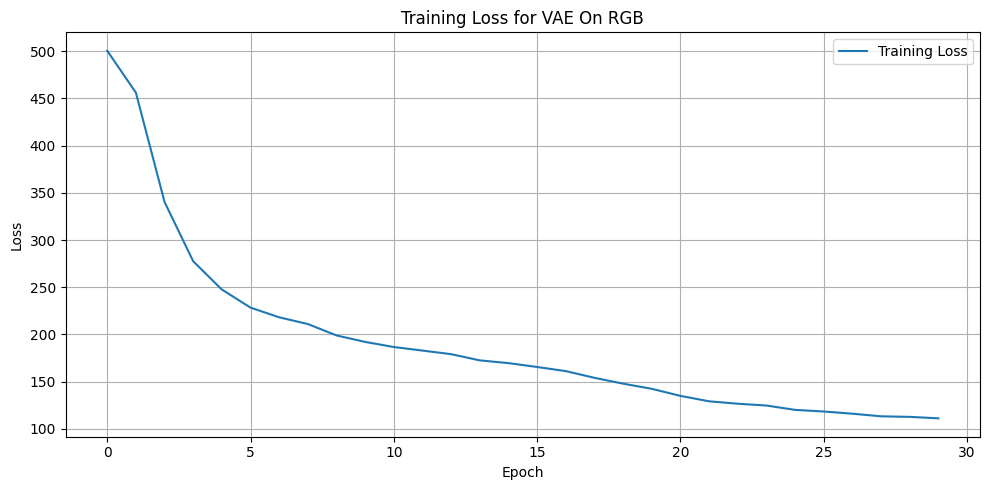

In [ ]:
vae2_encoder = VAEEncoder(input_channels=3, latent_dim=latent_dim).to(device)
vae2_decoder = VAEDecoder(latent_dim=latent_dim, output_channels=3).to(device)
vae2 = VAE(vae2_encoder, vae2_decoder).to(device)

vae2_optimizer = optim.Adam(vae2.parameters(), lr=0.001)

train_vae(vae2, gen_loader, vae2_optimizer, epochs, device)


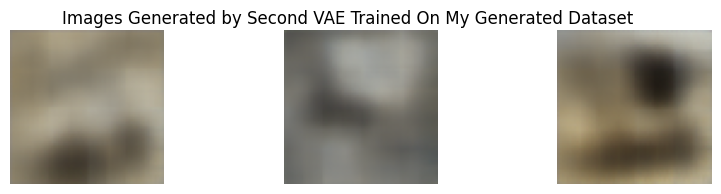

In [ ]:
vae2_generated_images = generate_images(vae2_decoder, latent_dim, num_images=10, device=device)
plot_images(vae2_generated_images[:3], title="Images Generated by Second VAE Trained On My Generated Dataset")


#Part4:Generate images with another technique(DCGAN)

Note : this part of code was run on kaggle

In [ ]:
import torchvision

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 64
LATENT_DIM = 100
LEARNING_RATE = 0.0002
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(output_size=(4, 4)),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

In [ ]:
generator = Generator(LATENT_DIM).to(DEVICE)
discriminator = Discriminator().to(DEVICE)
optimizer_g = optim.Adam(generator.parameters(), lr=LEARNING_RATE)
optimizer_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

Epoch [0/50] 


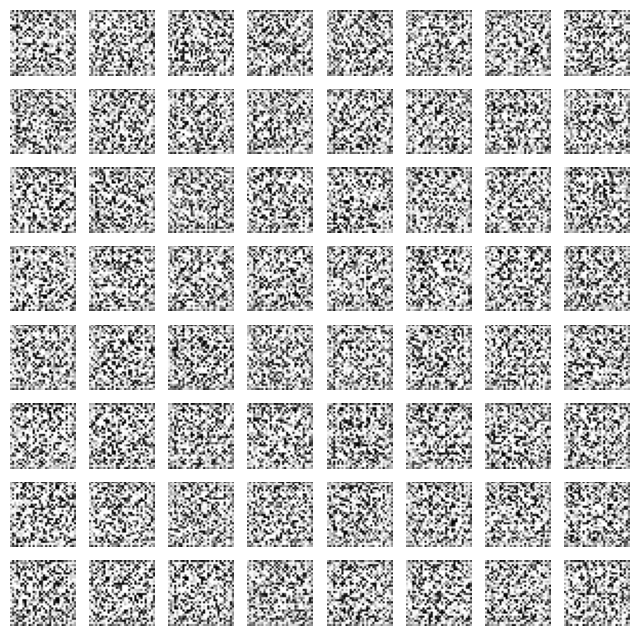

Epoch [1/50] 
Epoch [2/50] 
Epoch [3/50] 
Epoch [4/50] 
Epoch [5/50] 
Epoch [6/50] 
Epoch [7/50] 
Epoch [8/50] 
Epoch [9/50] 
Epoch [10/50] 


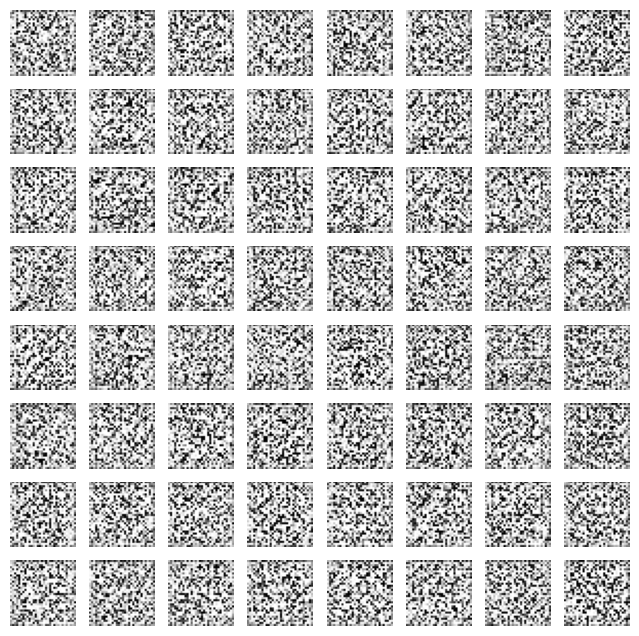

Epoch [11/50] 
Epoch [12/50] 
Epoch [13/50] 
Epoch [14/50] 
Epoch [15/50] 
Epoch [16/50] 
Epoch [17/50] 
Epoch [18/50] 
Epoch [19/50] 
Epoch [20/50] 


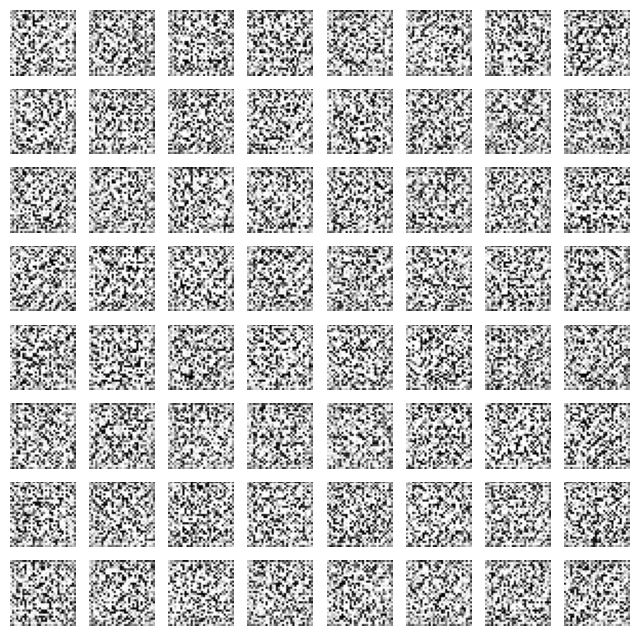

Epoch [21/50] 
Epoch [22/50] 
Epoch [23/50] 
Epoch [24/50] 
Epoch [25/50] 
Epoch [26/50] 
Epoch [27/50] 
Epoch [28/50] 
Epoch [29/50] 
Epoch [30/50] 


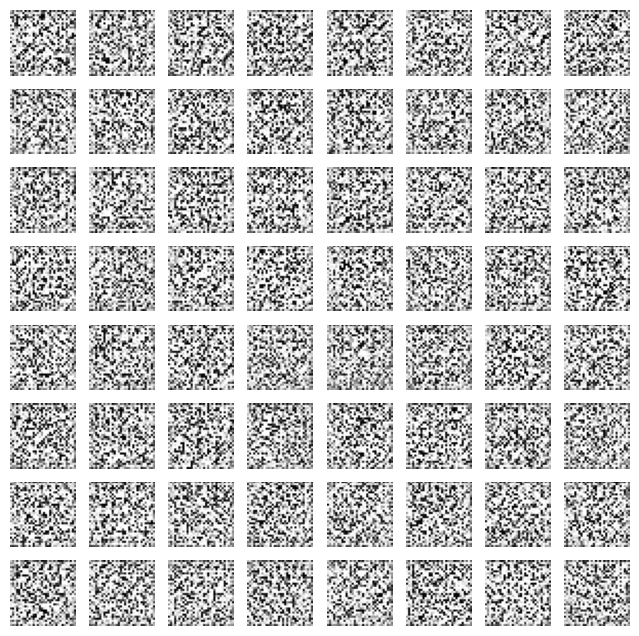

Epoch [31/50] 
Epoch [32/50] 
Epoch [33/50] 
Epoch [34/50] 
Epoch [35/50] 
Epoch [36/50] 
Epoch [37/50] 
Epoch [38/50] 
Epoch [39/50] 
Epoch [40/50] 


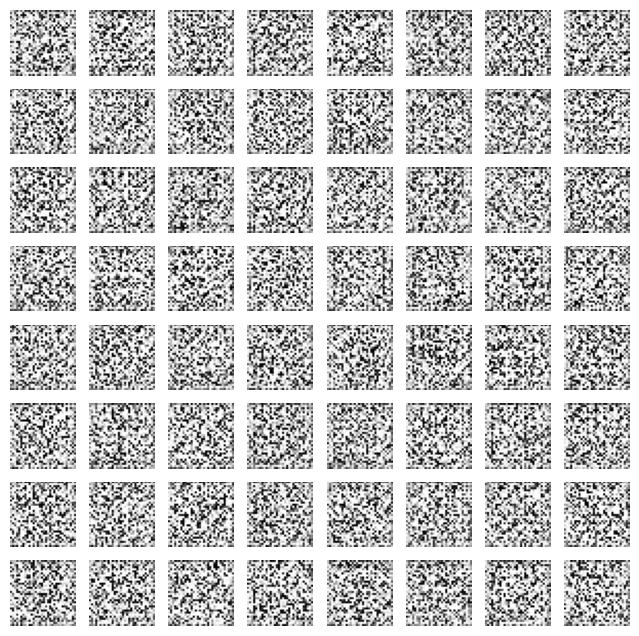

Epoch [41/50] 
Epoch [42/50] 
Epoch [43/50] 
Epoch [44/50] 
Epoch [45/50] 
Epoch [46/50] 
Epoch [47/50] 
Epoch [48/50] 
Epoch [49/50] 
Training finished!


In [ ]:
for epoch in range(EPOCHS):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(DEVICE)
        batch_size = real_images.size(0)
        batch_size = real_images.size(0)
        discriminator.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(DEVICE)
        fake_labels = torch.zeros(batch_size, 1).to(DEVICE)
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1).to(DEVICE)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()
        generator.zero_grad()
        outputs = discriminator(fake_images)
        outputs = discriminator(real_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()


    print(f"Epoch [{epoch}/{EPOCHS}] ")
    if epoch%10==0:
            noise = torch.randn(64, LATENT_DIM, 1, 1).to(DEVICE)
            generated_images = generator(noise).detach().cpu()
            fig, axes = plt.subplots(8, 8, figsize=(8, 8))
            for j, ax in enumerate(axes.flat):
                ax.imshow(generated_images[j].squeeze(), cmap='gray')
                ax.axis('off')
            plt.savefig(f"generated_images_epoch_{epoch}.png")
            plt.show()
            plt.pause(0.1)
            plt.close()

print("Training finished!")

#Part5: Compare VAE generated images VS DCGAN

Both VAE and DCGAN were trained on gray scale MNIST dataset,VAE In Part1 was trained for 30 epochs, DCGAN in part4 was trained for 50 epochs

while DCGAN was trained for a larger number of epocchs , results were bad and didn't display any features of the original datasets ,also DCGAN is computionally expensive and takes  longer time  to train.
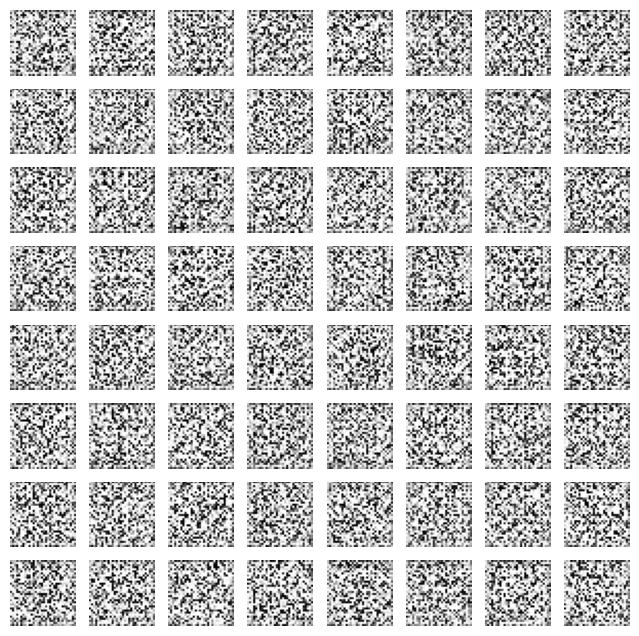

Conclusion : VAE is definitly better

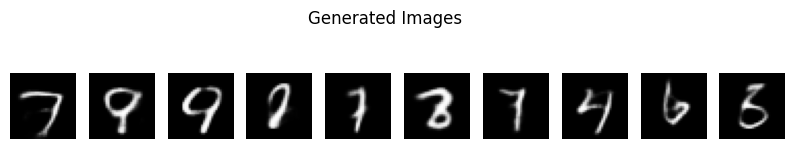